<a href="https://colab.research.google.com/github/AntonioBorz/Homework_SF_Mephi/blob/main/RPC_Borzunov_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -q -U kaggle_environments

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.0 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Loading environment lux_ai_s3 failed: No module named 'gymnax'


# **Вводим в игру трех базовых агентов (Камень, Бумага, Ножницы)**

1. Агент, всегда выбирающий камень (Камень - 0)

In [13]:
class RockAgent:
    def __call__(self, observation, configuration):
        # 0 - выбираем камень
        return 0

2. Агент, всегда выбирающий бумагу (Бумага - 1)

In [14]:
class PaperAgent:
    def __call__(self, observation, configuration):
        # 1 - выбираем бумагу
        return 1

3. Агент, всегда выбирающий ножницы (Ножницы - 2)

In [15]:
class ScissorsAgent:
    def __call__(self, observation, configuration):
        # 2 - выбираем ножницы
        return 2

# **Вводим в игру "хаотичного" агента**

4. Агент, делающий ход случайно (Рандом)

In [16]:
class RandomAgent:
    def __call__(self, observation, configuration):
        # свободный выбор камень/бумага/ножницы
        return random.randrange(0, configuration.signs)

# **Вводим в игру адаптирующихся агентов**

5. Агент, копирующий оппонента (Копия)

In [17]:
class CopyAgent:
    def __call__(self, observation, configuration):
        # если это не первый ход, то копируем предыдущий ход оппонента
        if observation.step > 0:
            return observation.lastOpponentAction
        # иначе возвращаем свободу выбора
        else:
            return random.randrange(0, configuration.signs)

6. Агент, реагирующий на ход оппонента (Реакция)

In [18]:
class ReactAgent:
    def __call__(self, observation, configuration):
        # если это первый ход, то оставляем свободу выбора
        if observation.step == 0:
            return random.randrange(0, configuration.signs)
        # на основе предыдущего хода оппонента агент выбирает ход, с которым он бы победил в предыдущем раунде
        return (observation.lastOpponentAction + 1) % configuration.signs

# **Вводим в игру последовательных агентов**

7. Агент, который ходит по порядку 0-1-2-0-1-2-... (Пошагово)

In [19]:
class MonotonousAgent:
    def __call__(self, observation, configuration):
        # если это первый ход, то оставляем свободу выбора
        if observation.step == 0:
            return random.randrange(0, configuration.signs)
        # иначе берем остаток от деления номера текущего эпизода на количество возможных вариантов
        return observation.step % configuration.signs

8. Агент, который ходит по порядку с повтором 0-0-1-1-2-2-0-0-... (ПовторПошагово)

In [20]:
class MonotonousRepeatAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = -1
        # инициализируем поле для хранения количества повторов
        self.repeats = 0

    def __call__(self, observation, configuration):
        # если это первый ход, то оставляем свободу выбора
        if self.last_step < 0:
            self.last_step = random.randrange(0, configuration.signs)
        # если повтора еще не было
        if self.repeats == 0:
            # увеличиваем количество повторов
            self.repeats += 1
        # если уже повторяли
        else:
            # сбрасываем счетчик повторов
            self.repeats = 0
            # увеличиваем значение последнего шага
            self.last_step = (self.last_step + 1) % configuration.signs
        # возвращаем значение поля, хранящего последний шаг
        return self.last_step

9. Агент, который ходит по порядку с двойным повтором 0-0-0-1-1-1-2-2-2-0-0-0-... (ПовторПошаговоХ2)

In [21]:
class MonotonousDoubleRepeatAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = -1
        # инициализируем поле для хранения количества повторов
        self.repeats = 0

    def __call__(self, observation, configuration):
        # если это первый ход, то оставляем свободу выбора
        if self.last_step < 0:
            self.last_step = random.randrange(0, configuration.signs)
        # если повтора еще не было
        if self.repeats == 0:
            # увеличиваем количество повторов
            self.repeats += 2
        # если уже повторяли
        else:
            # сбрасываем счетчик повторов
            self.repeats = 0
            # увеличиваем значение последнего шага
            self.last_step = (self.last_step + 1) % configuration.signs
        # возвращаем значение поля, хранящего последний шаг
        return self.last_step

10. Агент, который ходит через один шаг 0-2-1-0-2-1... (ЧерезШаг)

In [22]:
class MonotonousStepAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = -1

    def __call__(self, observation, configuration):
        # если это первый ход
        if self.last_step < 0:
            # возвращаем рандомное значение из доступных вариантов
            self.last_step = random.randrange(0, configuration.signs)
        # прибавляем 2 к своему последнему ходу
        return (self.last_step + 2) % configuration.signs

11. Агент, который ходит с чередованием 0/1/2 (Чередование1/3)

In [23]:
class PartAgent:
    def __init__(self):
        # инициализируем поле для хранения последнего хода
        self.last_step = 0
        # инициализируем поле для хранения  количества повторов
        self.repeats = 0

    def __call__(self, observation, configuration):
        # если количество повторов меньше 1/3 от запланированного количества эпизодов
        if self.repeats < (configuration.get('episodeSteps') / 3):
            # увеличиваем счетчик повторов
            self.repeats += 1
        # иначе переход к следующему значению
        else:
            # сбрасываем счетчик повторов
            self.repeats = 0
            # увеличиваем значение последнего шага
            self.last_step = (self.last_step + 1) % configuration.signs
        # возвращаем значение поля, хранящего последний шаг
        return self.last_step

## **Вводим в игру агента, анализирующего статистику**

12. Агент, который подсчитывает самый частый ход оппонента и соответственно реагирует

In [24]:
class StatisticalAgent:
    def __init__(self):
        # инициализируем переменную для хранения статистики
        self.action_histogram = {}

    def __call__(self, observation, configuration):
        # если это первый ход
        if observation.step == 0:
            # сбрасываем статистику
            self.action_histogram = {}
            # возвращаем свободу выбора
            return random.randrange(0, configuration.signs)
        # сохраняем в переменную последний ход оппонента
        action = observation.lastOpponentAction
        # если такого ключа еще нет в справочнике
        if action not in self.action_histogram:
            # добавляем в справочник со значением 0
            self.action_histogram[action] = 0
        # делаем инкремент счетчика для такого хода оппонента
        self.action_histogram[action] += 1

        # определяем статистически самый частый ход оппонента
        # инициализируем переменную для хранения хода с максимальным счетчиком
        mode_action = None
        # инициализируем переменную для хранения максимального значения счетчика
        mode_action_count = None
        # для каждой пары ключ-значение в справочнике статистики
        for k, v in self.action_histogram.items():
            # если значение в справочнике для этого ключа не установлено
            # или значение итератора больше значения в справочнике
            if mode_action_count is None or v > mode_action_count:
                # сохраняем текущий ключ в переменную максимума
                mode_action = k
                # сохраняем текущее значение в переменную максимума
                mode_action_count = v
                # переходим к следующей итерации
                continue
        # ходим так, чтобы победить самый частый ход оппонента
        return (mode_action + 1) % configuration.signs

# **Собираем справочник агентов**

In [25]:
agents = {
    'Камень': RockAgent(),
    'Бумага': PaperAgent(),
    'Ножницы': ScissorsAgent(),
    'Рандом': RandomAgent(),
    'Копия': CopyAgent(),
    'Реакция': ReactAgent(),
    'Пошагово': MonotonousAgent(),
    'ПовторПошагово': MonotonousRepeatAgent(),
    'ПовторПошаговоХ2': MonotonousDoubleRepeatAgent(),
    'ЧерезШаг': MonotonousStepAgent(),
    'Чередование1/3': PartAgent(),
    'Статистика': StatisticalAgent()
}

# **Организуем турнир**

In [39]:
class Tournament:

    def __init__(self, agents):

        # инициализируем атрибут со справочником агентов
        self.agents = agents
        # инициализируем справочник с результатами
        self.results = {}
        # для каждого ключа в справочнике агентов
        for agent in agents:
            # подготавливаем результат с 0 значением
            self.results[agent] = {'episodes_sum': 0, 'points': 0}

    # сохраняем результаты раунда
    def __save_result(self, round_result, left, right):

        # сохраняем в переменную количество побед в раунде левого агента
        left_wins = round_result[0][0]
        # сохраняем в переменную количество побед в раунде левого агента
        right_wins = round_result[0][1]
        # добавляем победы левого агента в результаты
        self.results[left]['episodes_sum'] += left_wins
        # добавляем победы правого агента в результаты
        self.results[right]['episodes_sum'] += right_wins
        # если у левого агента больше побед
        if left_wins > right_wins:
            # добавляем в результаты 2 очка левому агенту
            self.results[left]['points'] += 2
        # если у правого агента больше побед
        elif left_wins < right_wins:
            # добавляем в результаты 2 очка правому агенту
            self.results[right]['points'] += 2
        # иначе ничья
        else:
            # добавляем в результаты 1 очко левому агенту
            self.results[left]['points'] += 1
            # добавляем в результаты 1 очко правому агенту
            self.results[right]['points'] += 1

    def start(self, episodes):

        # собираем список имен агентов
        names = list(self.agents.keys())

        # проводим раунды для всех возможных пар агентов
        # для числа i от 0 до количества агентов уменьшенного на 1
        # i будет представлять индекс левого агента в раунде
        for i in range(len(names) - 1):
            # для числа j от 0 до количества агентов уменьшенного на 1
            for j in range(len(names) - 1):
                # определяем индекс правого агента
                index = j + 1 + i
                # если вычисленный индекс превысил макимальный индекс
                if index > (len(names) - 1):
                    # выходим из цикла
                    break
                # сохраняем в переменную имя левого агента
                left = names[i]
                # сохраняем в переменную имя правого агента
                right = names[index]
                # проводим раунд и сохраняем результат в переменную
                round_result = evaluate(
                    "rps", #environment to use - no need to change
                    [agents[left], agents[right]], #agents to evaluate
                    configuration={"episodeSteps": episodes}, #episodes
                    debug=True
                )
                # сохраняем результат раунда
                self.__save_result(round_result, left, right)

    # выводим результаты турнира
    def print_result(self):

        # сортируем результат по полученным очкам
        sorted_table_p = dict(
            sorted(
                self.results.items(),
                key=lambda x: (x[1].get('points'), x[1].get('episodes_sum')),
                reverse=True
                )
            )
        # собираем список имен агентов в отсортированном порядке
        names_p = [name for name in sorted_table_p]
        # собираем список очков в отсортированном порядке
        points = [x[1].get('points') for x in sorted_table_p.items()]

        # создаем и отображаем график
        dfp = pd.DataFrame({"agent": names_p, "point": points})
        plt.figure(figsize=(25, 5))
        splot = sns.barplot(x="agent",y="point",data=dfp)
        plt.xlabel("Агент", size=16)
        plt.ylabel("Набранные очки", size=16)
        plt.bar_label(splot.containers[0],size=16,label_type='center')
        plt.suptitle('По набранным очкам')
        plt.show()

        # сортируем результат по сумме выигранных эпизодов
        sorted_table_e = dict(
            sorted(
                self.results.items(),
                key=lambda x: (x[1].get('episodes_sum'), x[1].get('points')),
                reverse=True
                )
            )
        # собираем список имен агентов в отсортированном порядке
        names_e = [name for name in sorted_table_e]
        # собираем список сумм выигранных эпизодов в отсортированном порядке
        ep_sum = [x[1].get('episodes_sum') for x in sorted_table_e.items()]

        # создаем и отображаем график
        dfe = pd.DataFrame({"agent": names_e, "win": ep_sum})
        plt.figure(figsize=(25, 5))
        splot=sns.barplot(x="agent",y="win",data=dfe)
        plt.xlabel("Агент", size=16)
        plt.ylabel("Количество игр", size=16)
        plt.bar_label(splot.containers[0],size=16, label_type='center')
        plt.suptitle('По количеству игр')
        plt.show()

# **ТУРНИР**

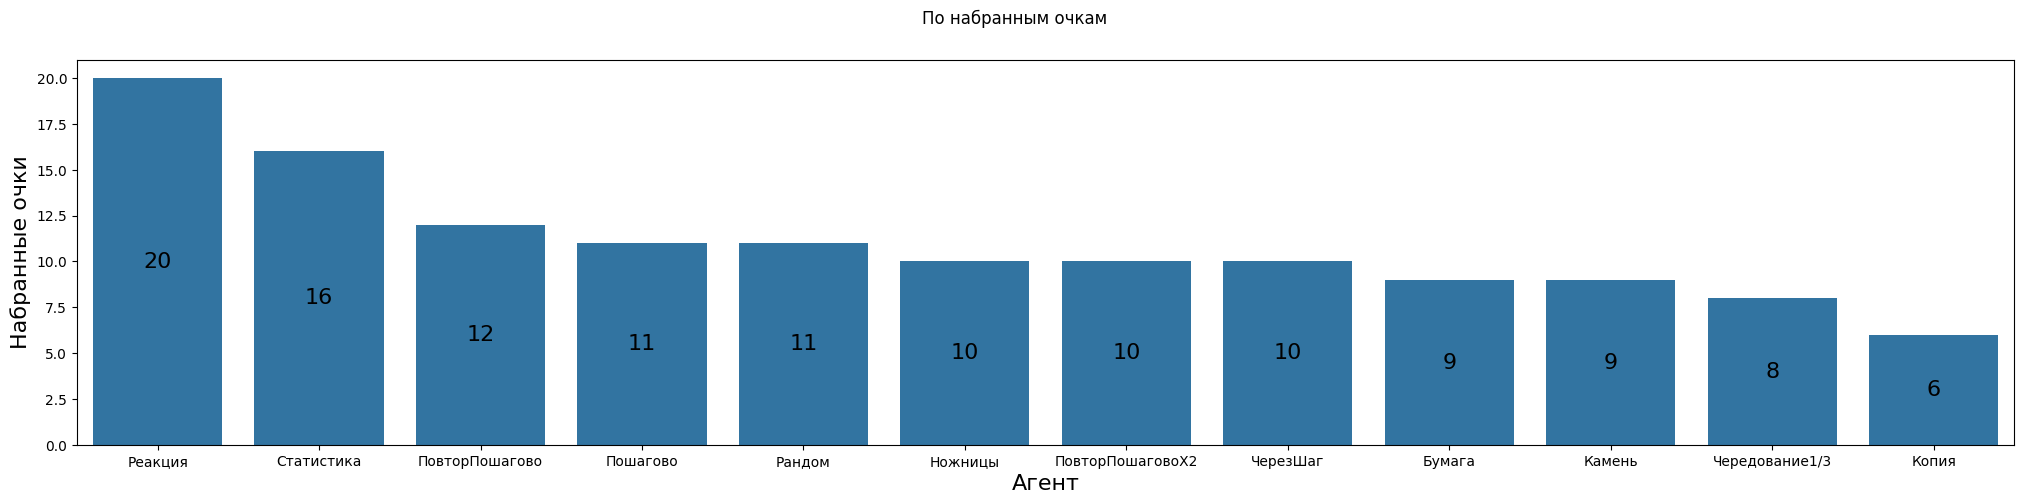

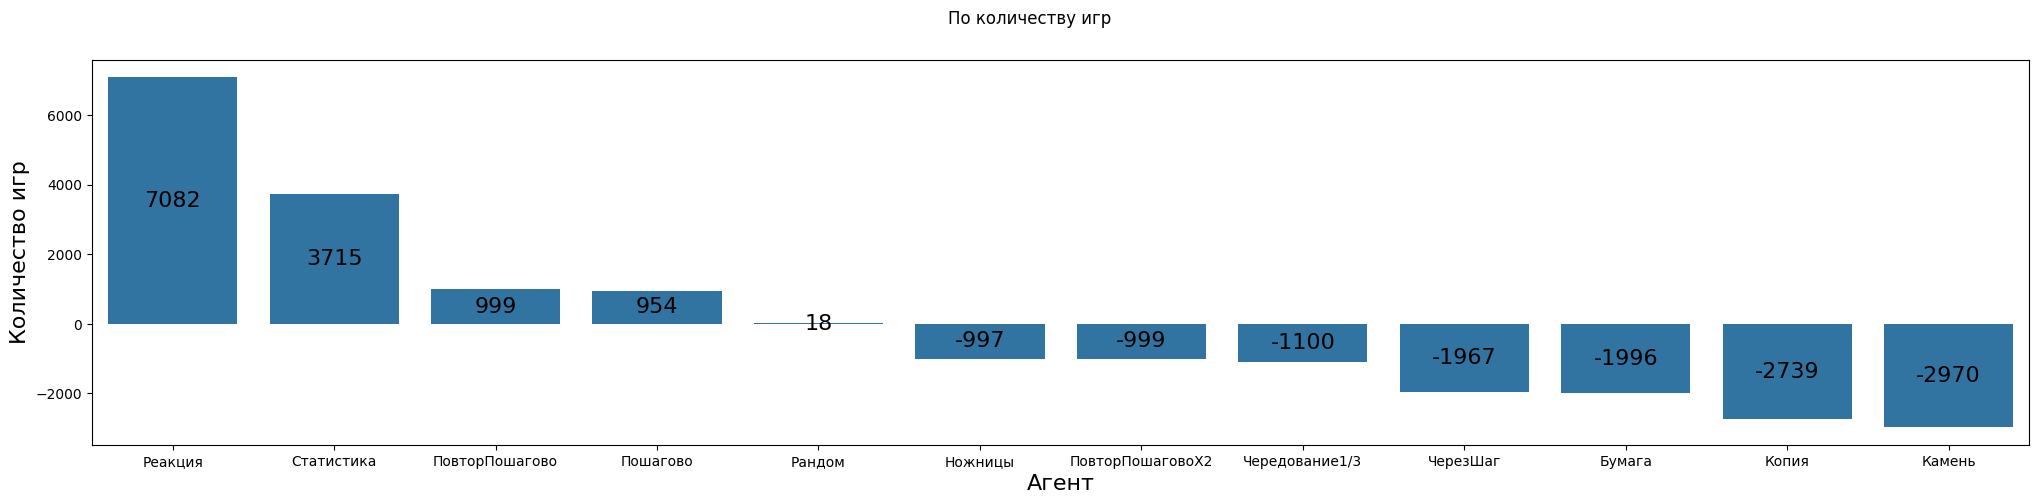

In [40]:
# создаем турнир, передав подготовленный справочник агентов
tournament = Tournament(agents)
# запускаем турнир, передав количество эпизодов в раунде
tournament.start(1000)
# отображаем результат турнира
tournament.print_result()

# **ВЫВОД**

В подавляющем большинстве случаев побеждают агенты:
- реагирующие на ходы оппонентов;
- анализирующее статистику предыдущих ходов оппонентов.